In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_score

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan

In [3]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43909 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43909/status,
Dashboard: http://127.0.0.1:43909/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38721,Workers: 8
Dashboard: http://127.0.0.1:43909/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:36431,Total threads: 2
Dashboard: http://127.0.0.1:45765/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:39761,


In [4]:
suffix = '_rgb_tpi_ndvi_5cm'
cell_size = 5.0
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'
focal_area_ha = 5.0
burrow_area_thresh = None

In [5]:
cper = gpd.read_file(cper_f)
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))
cper_xr = cper_xr.where(cper_xr != 0)

In [6]:
hls_xr = riox.open_rasterio('/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2021_gcloud.nc',
                            decode_times=True,
                            chunks={'date': -1, 'x': 50, 'y': 50},
                            masked=True)
hls_xr

<xarray.Dataset>
Dimensions:      (date: 365, x: 323, y: 325)
Coordinates:
  * date         (date) object 2021-01-01 00:00:00 ... 2021-12-31 00:00:00
  * x            (x) float64 -1.167e+07 -1.167e+07 ... -1.165e+07 -1.165e+07
  * y            (y) float64 4.993e+06 4.993e+06 4.993e+06 ... 4.98e+06 4.98e+06
    spatial_ref  int64 0
Data variables:
    BARE         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    GREEN        (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SD           (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    LITT         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass      (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass_SE   (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    DRYVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NONVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes:
    add_offset:    0
    scale_factor:  1
    _FillValue:    3.402823466385289e+38

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rasterio/plot.py:149: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(arr, **kwargs)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rasterio/plot.py:149: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(arr, **kwargs)


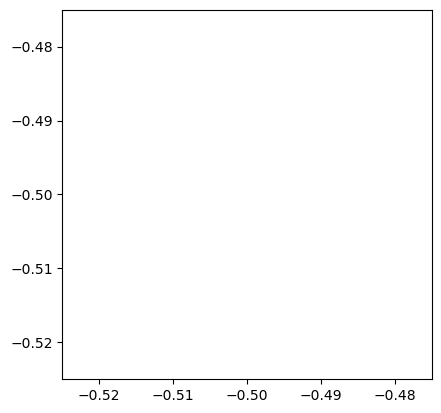

<AxesSubplot:>

In [7]:
bm_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['Biomass'].isel(date=slice(165, 244)),
                          input_core_dims=[['date']],
                          vectorize=True,
                          dask='parallelized')
bm_slope = bm_slope.rio.reproject('EPSG:32613').where(bm_slope != bm_slope.rio.nodata).compute()
bm_slope = bm_slope.where((bm_slope > -20) & (bm_slope < 20))
bm_slope_z = (bm_slope - bm_slope.mean()) / bm_slope.std()
show(bm_slope_z.data, clim=(-2.0, 2.0))

In [8]:
bm_slope

<xarray.DataArray 'Biomass' (y: 0, x: 0)>
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * x            (x) float64 
  * y            (y) float64 
    spatial_ref  int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

In [9]:
#bm_slope_z.rio.to_raster('./cnn_pred_results/tifs/bm_slope_z_julaug.tif')

In [10]:
bare_sub = hls_xr['BARE'].isel(date=slice(235, 265)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bare_sub = bare_sub.where(bare_sub != bare_sub.rio.nodata)
bare_z = (bare_sub - bare_sub.mean()) / bare_sub.std()

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


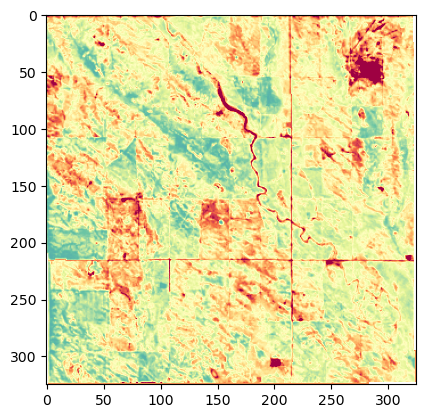

<AxesSubplot:>

In [11]:
show(bare_z.data, cmap='Spectral_r', clim=(-3.0, 3.0))

In [12]:
pts_list = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/it]


In [13]:
pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_density_xr = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)
pts_density_xr = pts_density_xr / focal_area_ha

/tmp/ipykernel_4229/851037890.py:1: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


In [17]:
pts_density_xr.rio.to_raster('./cnn_pred_results/tifs/burrow_density_' + suffix + '.tif')

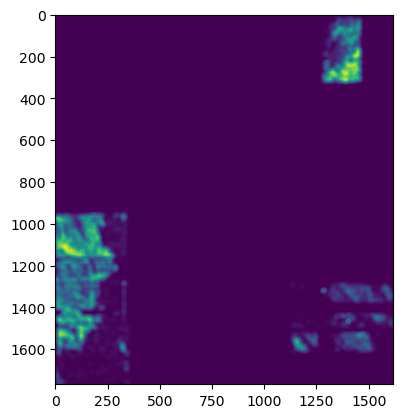

<AxesSubplot:>

In [15]:
show(pts_density_xr.data)
#pts_density_xr.isnull().all()

In [40]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

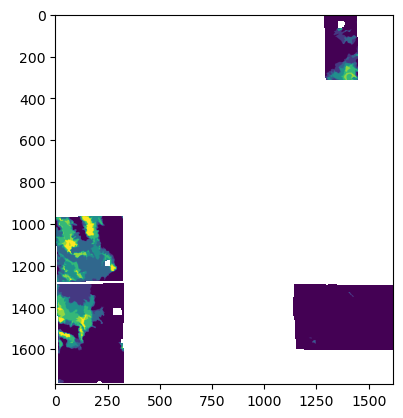

<AxesSubplot:>

In [41]:
show(da_active.data)

In [42]:
pts_density_xr = pts_density_xr.where(da_active.notnull())

In [43]:
df_active = da_active.to_dataframe(name='yrs_active').drop(columns='spatial_ref')
df_old = da_old.to_dataframe(name='yrs_old').drop(columns='spatial_ref')
df_pts_density = pts_density_xr.to_dataframe(name='pts_density').drop(columns='spatial_ref')

In [44]:
bm_slope_z = bm_slope_z.reindex_like(pts_density_xr, method='nearest')
df_bm_slope = bm_slope_z.to_dataframe(name='bm_slope_z').drop(columns='spatial_ref')

In [58]:
bare_z = bare_z.reindex_like(pts_density_xr, method='nearest')
df_bare = bare_z.to_dataframe(name='bare_z').drop(columns='spatial_ref')

In [59]:
df_out = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                df_active, df_old, left_index=True, right_index=True),
            df_pts_density, left_index=True, right_index=True),
        df_bm_slope, left_index=True, right_index=True),
    df_bare, left_index=True, right_index=True)
    

In [60]:
df_out

band_x  yrs_active  band_y  yrs_old  band  \
y            x                                                        
4.524365e+06 519167.8595       1         NaN       1      NaN     1   
             519172.8595       1         NaN       1      NaN     1   
             519177.8595       1         NaN       1      NaN     1   
             519182.8595       1         NaN       1      NaN     1   
             519187.8595       1         NaN       1      NaN     1   
...                          ...         ...     ...      ...   ...   
4.515525e+06 527232.8595       1         NaN       1      NaN     1   
             527237.8595       1         NaN       1      NaN     1   
             527242.8595       1         NaN       1      NaN     1   
             527247.8595       1         NaN       1      NaN     1   
             527252.8595       1         NaN       1      NaN     1   

                          pts_density  bm_slope_z    bare_z  
y            x                                               
4.524365e+06 519167.8595          NaN   -0.222503  0.821674  
             519172.8595          NaN    0.075738  0.762297  
             519177.8595          NaN    0.075738  0.762297  
             519182.8595          NaN    0.075738  0.762297  
             519187.8595          NaN    0.075738  0.762297  
...                               ...         ...       ...  
4.515525e+06 527232.8595          NaN    5.362992 -0.355520  
             527237.8595          NaN    5.362992 -0.355520  
             527242.8595          NaN    6.592637 -0.411841  
             527247.8595          NaN    6.592637 -0.411841  
             527252.8595          NaN    6.592637 -0.411841  

[2862242 rows x 8 columns]

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

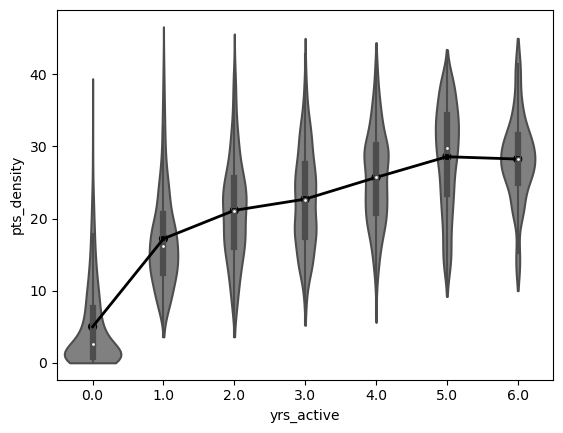

In [61]:
ax = sns.violinplot(x='yrs_active', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_active', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

<AxesSubplot:xlabel='yrs_old', ylabel='pts_density'>

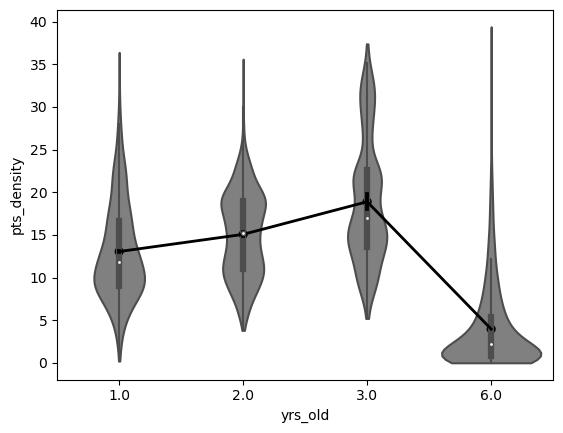

In [62]:
ax = sns.violinplot(x='yrs_old', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_old', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

In [50]:
df_val = pd.DataFrame(columns=['yrs_thresh', 'pts_thresh', 'jscore'])
idx=0
for yrs_thresh in tqdm(range(0, 6)):
    for pts_thresh in range(0, 51, 2):
        df_out['y_true'] = df_out['yrs_active'] > yrs_thresh
        df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
        jscore = jaccard_score(y_true=df_out['y_true'],
                      y_pred=df_out['y_pred'])
        df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': yrs_thresh,
                                                  'pts_density': pts_thresh,
                                                  'jscore': jscore}, index=[idx])])
        idx+=1

100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.61s/it]


In [51]:
for pts_thresh in tqdm(range(0, 51, 2)):
    df_out['y_true'] = (df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)
    df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': -1,
                                              'pts_density': pts_thresh,
                                              'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [00:14<00:00,  1.75it/s]


In [64]:
df_out['box_x'] = df_out.apply(lambda x: -1 if x['yrs_old'] == 1 else x['yrs_active'], axis=1)
df_out_boxplot = df_out.loc[df_out['box_x'].notnull()].copy()

In [65]:
df_out_boxplot['box_x'] = df_out_boxplot['box_x'].astype('int')
df_out_boxplot['box_x'][df_out_boxplot['box_x'] == 0] = 'N/A'

/tmp/ipykernel_9476/548756497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_boxplot['box_x'][df_out_boxplot['box_x'] == 0] = 'N/A'


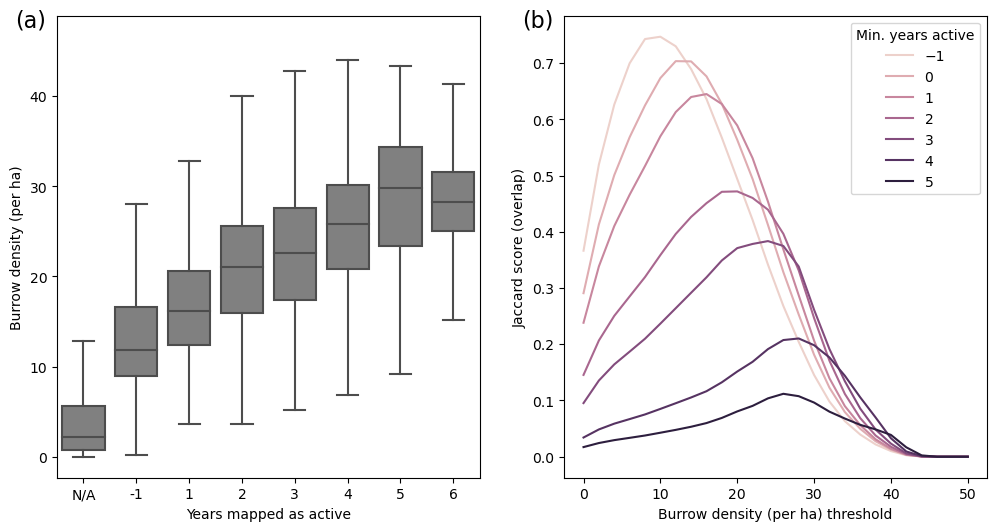

In [66]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='box_x', y='pts_density', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='pts_density', y='jscore', data=df_val, hue='yrs_thresh', ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Burrow density (per ha) threshold')
axs[1].legend(title='Min. years active')

axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

plt.savefig('./results_figs/colony_age_and_burrow_density_plot' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [55]:
df_val_smry = pd.DataFrame(df_val.groupby('yrs_thresh').apply(
    lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])).droplevel(level=1)
df_val_smry['jscore'] = df_val.groupby('yrs_thresh').apply(lambda x: x['jscore'].max())
display(round(df_val_smry, 2))

,pts_density,jscore
yrs_thresh,,
-1,10.0,0.75
0,12.0,0.70
1,16.0,0.64
2,20.0,0.47
3,24.0,0.38
4,28.0,0.21
5,26.0,0.11


In [56]:
df_bm_slope_val = pd.DataFrame(columns=['bm_slope_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bm_slope_z'] < zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bm_slope_val = pd.concat([df_bm_slope_val, pd.DataFrame({'bm_slope_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.18it/s]


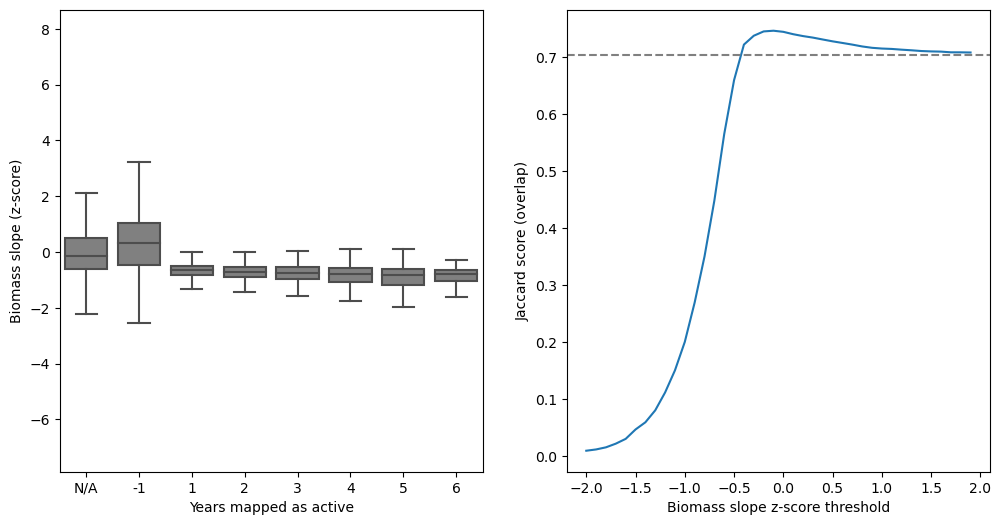

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bm_slope_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Biomass slope (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bm_slope_z', y='jscore', data=df_bm_slope_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Biomass slope z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [71]:
df_bm_slope_val[(df_bm_slope_val['jscore'].max() - df_bm_slope_val['jscore']) < 0.005]

,bm_slope_z,jscore
18,-2.000000e-01,0.744975
19,-1.000000e-01,0.746205
20,1.776357e-15,0.744250


In [80]:
df_bare_val = pd.DataFrame(columns=['bare_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bare_z'] > zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bare_val = pd.concat([df_bare_val, pd.DataFrame({'bare_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


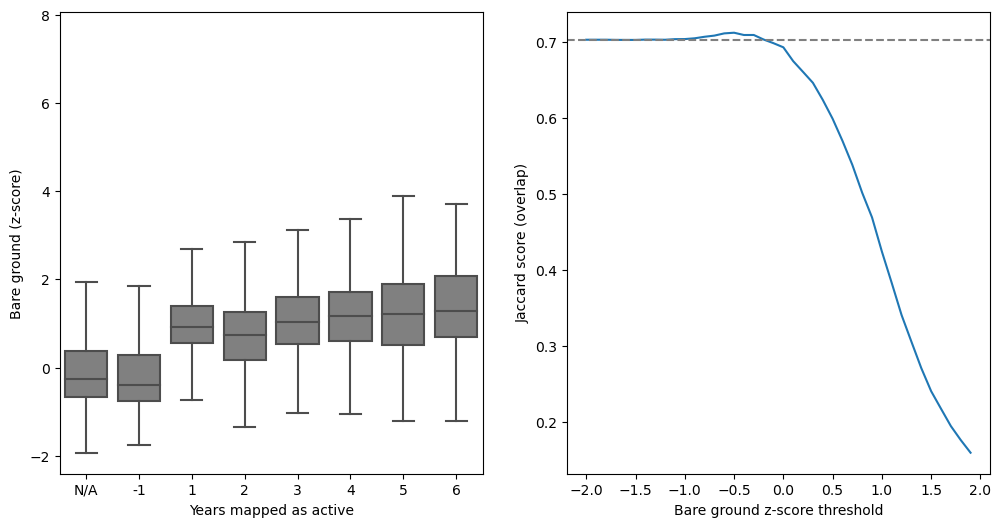

In [81]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bare_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Bare ground (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bare_z', y='jscore', data=df_bare_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Bare ground z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [82]:
df_bare_val[(df_bare_val['jscore'].max() - df_bare_val['jscore']) < 0.005]

,bare_z,jscore
13,-0.7,0.708868
14,-0.6,0.711793
15,-0.5,0.712667
16,-0.4,0.709671
17,-0.3,0.709687


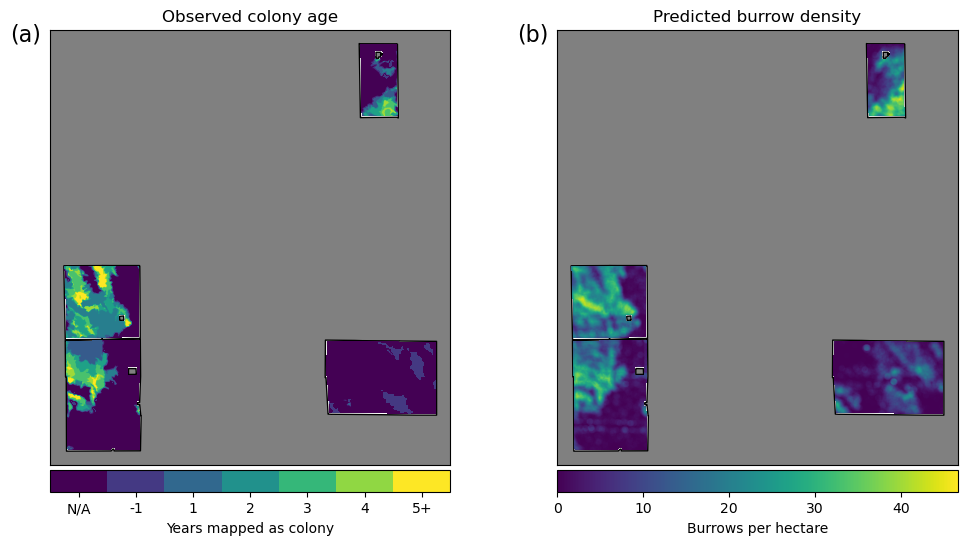

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_buff_m = 300
cper.plot(fc='white', ec='black', ax=axs[0])
show(da_active.data, ax=axs[0], transform=da_active.rio.transform(), zorder=5)
show(da_old.where(da_old == 1).data, ax=axs[0], transform=da_old.rio.transform(), clim=(0, 6), zorder=8)
p_active = show(da_active.where(da_active > 0).data, ax=axs[0], transform=da_active.rio.transform(),
                clim=(-1, 6), zorder=10)
axs[0].set_title('Observed colony age')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density = show(pts_density_xr.data, ax=axs[1], transform=pts_density_xr.rio.transform(), zorder=10)
axs[1].set_title('Predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
    ax.set_facecolor('grey')
axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

# colorbar for first plot
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = ColorbarBase(ax=cax1, 
                     cmap=plt.get_cmap('viridis', 7), 
                     norm=BoundaryNorm(np.arange(0, 8), 8),
                     ticks=np.arange(0.5, 7.5),
                     label='Years mapped as colony',
                     orientation='horizontal')
cbar1.ax.set_xticklabels(['N/A', -1, 1, 2, 3, 4, '5+'])  # horizontal colorbar

# colorbar for second plot
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density.get_images()[0],
             cax=cax2,
             orientation='horizontal', 
             label='Burrows per hectare')
plt.savefig('./results_figs/colony_age_and_burrow_density_map' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

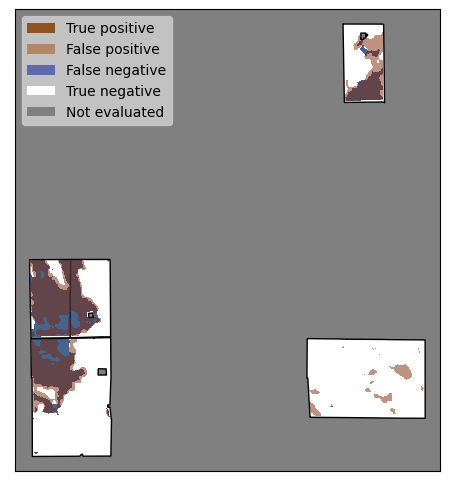

In [75]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where(pts_density_xr >= pts_thresh).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [76]:
print('Colony area predicted from burrow density: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   414.5 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   372.0 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


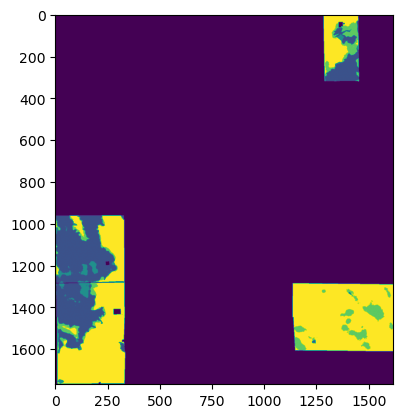

<AxesSubplot:>

In [100]:
da_result = xr.zeros_like(da_active)
da_result = da_result + ((da_active > 0) & (pts_density_xr >= pts_thresh))
da_result = da_result + ((da_active > 0) & (pts_density_xr < pts_thresh)) * 2
da_result = da_result + ((da_active == 0) & (pts_density_xr >= pts_thresh)) * 3
da_result = da_result + ((da_active == 0) & (pts_density_xr < pts_thresh)) * 4
show(da_result.data, clim=(0, 4))

In [ ]:
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

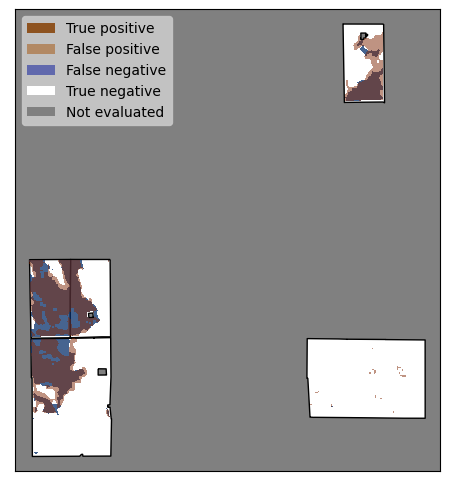

In [83]:
bm_slope_thresh = -0.2

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + 'with_bm_thresh.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [84]:
print('Colony area predicted from burrow density: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   375.1 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   361.5 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha
